# <center>Построение пуассоновской регрессии

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Чтение и подготовка данных

Рассмотрим данные о количестве велосипедистов. Количество велосипедистов зависит от погодных условий в рассматриваемый день: чем хуже погода, тем меньше желающих. В качестве признаков возьмем:
- максимальную температуру в рассматриваемый день (F);
- минимальную температуру в рассматриваемый день (F);
- количество осадков.

In [2]:
data = pd.read_csv('data/nyc_bicyclist_counts.csv', index_col=['Date'], parse_dates=True)

In [3]:
data.head()

,HIGH_T,LOW_T,PRECIP,BB_COUNT
Date,,,,
2017-04-01,46.0,37.0,0.00,606
2017-04-02,62.1,41.0,0.00,2021
2017-04-03,63.0,50.0,0.03,2470
2017-04-04,51.1,46.0,1.18,723
2017-04-05,63.0,46.0,0.00,2807


Целевая переменная &ndash; `'BB_COUNT'` &ndash; содержит только целые положительные числа, что должно быть учтено при выборе предсказательной модели.

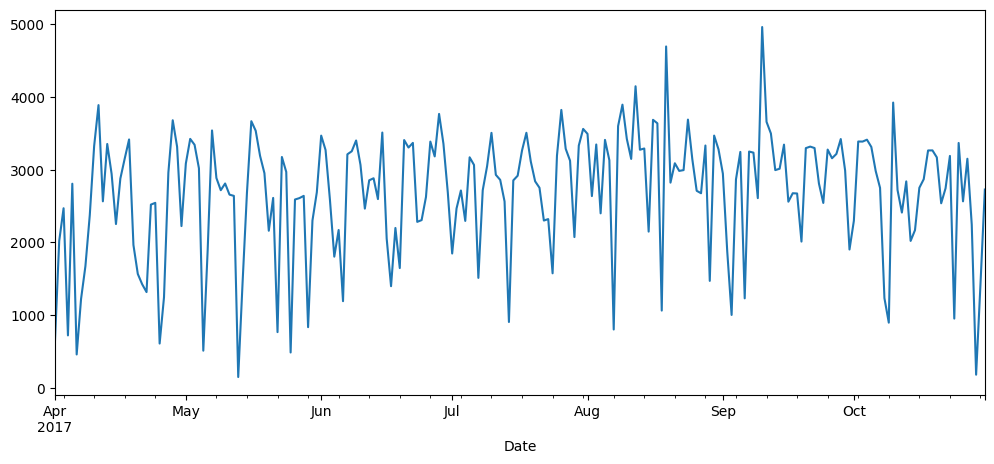

In [4]:
data['BB_COUNT'].plot(figsize=(12,5))
plt.show()

Кроме указанных факторов, количество велосипедистов может зависеть от дня недели: в выходные количество желающих больше, нежели в будни. Также может оказаться важным месяц. Добавим столбцы, содержащие информацию о том, на какой день недели и на какой месяц приходится наблюдение:

In [5]:
data['DAY_OF_WEEK'] = data.index.dayofweek
data['MONTH'] = data.index.month

In [6]:
data['const'] = 1

Данные переменные являются категориальными.

<div class="alert alert-info">

<h3> Задание 1</h3>
<p></p>
<ul>1. Определите функцию, которая принимает на вход исходные данные $(X,y)$ и параметры модели $\theta$. Данная функция должна возвращать среднеквадратичную ошибку модели.</ul>
    
<ul>2. Определите аналогичную функцию, которая возвращает значение функционала качества пуассоновской регрессии.</ul>  
    
<ul>3. Обучите обе модели с помощью функции minimize из SciPy. Сравните качество аппроксимации моделей. Метрикой качества выберите среднюю абсолютную ошибку.</ul>    
 
<ul>4. Отобразите на графике исходный ряд и результаты аппроксимации линейной и пуассоновской регрессиями.</ul>
<p></p>   

<p></p>
</div>

In [7]:
from scipy.optimize import minimize

In [31]:
from sklearn.metrics import mean_absolute_error

1. Сначала сделаем функции для mse и пуассоновского функционала

In [82]:
def my_mse(X, y, thetas):
    l = X.shape[0]
    res = sum((np.dot(thetas, np.transpose(X)) - y)**2)
    return res/l

In [83]:
def get_optimal_params_mse(X, y):
    l = X.shape[1]
    return minimize(lambda x: my_mse(X, y, [x[i] for i in range(l)]), ([0 for _ in range(l)]))

In [90]:
def my_poissonfunc(X, y, thetas):
    l = X.shape[0]
    lin_comb = np.dot(thetas, np.transpose(X))
    res = np.dot(y, np.transpose(lin_comb)) - sum(np.expm1(lin_comb))
    return -res/l

In [91]:
def get_optimal_params_poissonfunc(X, y):
    l = X.shape[1]
    return minimize(lambda x: my_poissonfunc(X, y, [x[i] for i in range(l)]), ([0 for _ in range(l)]))


2. Определим оптимальные параметры с помощью созданных функций для mse и пуассоновского функционала

In [84]:
X = data.drop('BB_COUNT', axis=1)
y = data['BB_COUNT']

In [85]:
get_optimal_params_mse(X, y)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 322765.4645103819
        x: [ 6.942e+01 -4.674e+01 -9.581e+02 -5.442e+01  3.686e+01
             4.605e+02]
      nit: 27
      jac: [ 4.688e-02  2.344e-02  0.000e+00  1.953e-02  2.344e-02
            -3.906e-03]
 hess_inv: [[ 1.782e-07  7.067e-07 ... -1.440e-07  5.622e-07]
            [ 7.067e-07  3.334e-06 ... -6.647e-07  2.484e-06]
            ...
            [-1.440e-07 -6.647e-07 ...  1.335e-07 -4.980e-07]
            [ 5.622e-07  2.484e-06 ... -4.980e-07  1.903e-06]]
     nfev: 539
     njev: 77

In [92]:
get_optimal_params_poissonfunc(X, y)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -18572.93228652455
        x: [ 2.410e-02 -1.472e-02 -7.785e-01 -2.251e-02  1.327e-02
             7.045e+00]
      nit: 20
      jac: [-3.906e-03 -4.150e-03  2.441e-04 -2.441e-04 -9.766e-04
             0.000e+00]
 hess_inv: [[ 1.664e-05 -1.939e-05 ... -4.258e-06 -5.283e-07]
            [-1.939e-05  2.386e-05 ... -5.118e-06  5.092e-06]
            ...
            [-4.258e-06 -5.118e-06 ...  9.511e-05 -1.400e-05]
            [-5.283e-07  5.092e-06 ... -1.400e-05  1.021e-04]]
     nfev: 446
     njev: 62

3. Отобразим на графике полученные аппроксимации для полученных параметров по mse и пуассоновскому функционалу

In [93]:
def my_forecast_values_mse(X, thetas): # для удобства получения массива полученных аппроксимационных значений
    y_forc = np.dot(thetas, np.transpose(X))
    return y_forc

In [94]:
forecast_mse=my_forecast_values_mse(X, [6.942e+01, -4.674e+01, -9.581e+02, -5.442e+01, 3.686e+01, 4.605e+02])
df_forecast_mse=pd.DataFrame(forecast_mse)
df_forecast_mse.index=data.index
df_forecast_mse.columns=['forecast_mse']

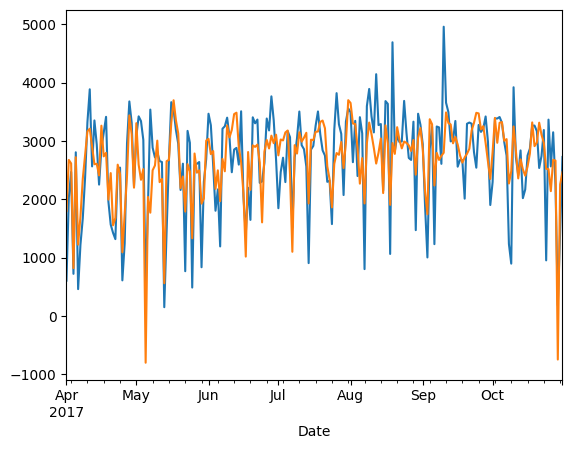

In [95]:
data['BB_COUNT'].plot()
df_forecast_mse['forecast_mse'].plot()
plt.show()

In [96]:
def my_forecast_values_poissonfunc(X, thetas): # для удобства получения массива полученных аппроксимационных значений
    y_forc = np.expm1(np.dot(thetas, np.transpose(X)))
    return y_forc

In [97]:
forecast_poissonfunc=my_forecast_values_poissonfunc(X, [2.410e-02, -1.472e-02, -7.785e-01, -2.251e-02, 1.327e-02, 7.045e+00])
df_forecast_poissonfunc=pd.DataFrame(forecast_poissonfunc)
df_forecast_poissonfunc.index=data.index
df_forecast_poissonfunc.columns=['forecast_poissonfunc']

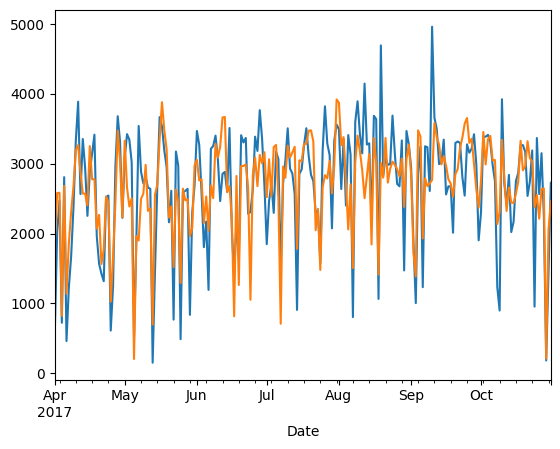

In [98]:
data['BB_COUNT'].plot()
df_forecast_poissonfunc['forecast_poissonfunc'].plot()
plt.show()

4. Сравним полученные результаты с помощью MAE 

In [99]:
mean_absolute_error(y, df_forecast_mse['forecast_mse'])

436.49116822429914

In [100]:
mean_absolute_error(y, df_forecast_poissonfunc['forecast_poissonfunc'])

418.99338388922644

Результаты, полученные с помощью минимизации пуассоновского функционала оказались лучше

<div class="alert alert-info">

<h3> Задание 2</h3>
<p></p>
<ul>Линейные модели чувствительны к виду категориальных признаков. Преобразуйте категориальные признаки с помощью One Hot Encoding и повторите шаги 3-4 из задания 1. Как изменилось качество моделей?</ul>
<p></p>
</div>

1. Преобразуем датафрейм с учетом категориальных признаков

In [101]:
encoded_data = pd.get_dummies(data, columns=['DAY_OF_WEEK', 'MONTH'])

In [102]:
encoded_data
encoded_data.columns = ['HIGH_T', 'LOW_T', 'PRECIP', 'BB_COUNT', 'const', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

2. Получим оптимальные параметры, взяв полученные фиктивные переменные в линейную регрессию

In [104]:
X = encoded_data.drop('BB_COUNT', axis=1)
y = encoded_data['BB_COUNT']

In [105]:
get_optimal_params_mse(X, y)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 295305.7047571346
        x: [ 7.177e+01 -5.611e+01 ...  1.812e+02  1.003e+02]
      nit: 49
      jac: [ 2.344e-02  3.906e-03 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 4.125e-02 -4.201e-02 ... -4.328e-01  5.843e-01]
            [-4.201e-02  4.317e-02 ...  4.265e-01 -5.705e-01]
            ...
            [-4.328e-01  4.265e-01 ...  5.333e+00 -7.316e+00]
            [ 5.843e-01 -5.705e-01 ... -7.316e+00  1.045e+01]]
     nfev: 1254
     njev: 66

In [118]:
get_optimal_params_poissonfunc(X, y)

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -18577.40368439906
        x: [ 2.508e-02 -1.904e-02 ...  8.377e-01  7.920e-01]
      nit: 31
      jac: [ 9.961e-02  7.861e-02 ...  9.766e-04  0.000e+00]
 hess_inv: [[ 2.347e-05 -2.361e-05 ... -9.564e-06 -1.175e-05]
            [-2.361e-05  3.368e-05 ...  3.305e-06  7.663e-05]
            ...
            [-9.564e-06  3.305e-06 ...  1.135e-01  1.103e-01]
            [-1.175e-05  7.663e-05 ...  1.103e-01  1.141e-01]]
     nfev: 1045
     njev: 55

3. Получим проноз в соответствии с полученными параметрами

In [109]:
forecast_mse_encoded=my_forecast_values_mse(X, [71.76803943, -56.10601744, -927.37597758, 745.69098658, 77.29444189, 
                                                251.6114931, 247.33417618, 322.94108603, 90.83440008, -111.37587727,
                                                -134.0025722, -199.7481865, 76.04554167, 132.08544329, 99.24790396,
                                                354.29357895, 181.22757367, 100.25041768])
df_forecast_mse_encoded=pd.DataFrame(forecast_mse_encoded)
df_forecast_mse_encoded.index=data.index
df_forecast_mse_encoded.columns=['forecast_mse_encoded']

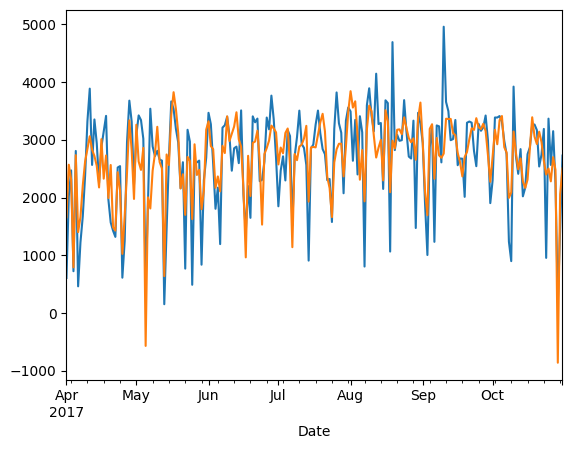

In [111]:
encoded_data['BB_COUNT'].plot()
df_forecast_mse_encoded['forecast_mse_encoded'].plot()
plt.show()

In [119]:
forecast_poissonfunc_encoded=my_forecast_values_poissonfunc(X, [0.02507801, -0.0190416, -0.76589647, 5.64865477, 0.8175594,
                                                                0.86363983,  0.85357367,  0.87244136,  0.79797757,  0.74458512,
                                                                0.70281188,  0.68885002,  0.78002512,  0.83346652,  0.81628278,
                                                                0.90477079,  0.8377308 ,  0.79195208])
df_forecast_poissonfunc_encoded=pd.DataFrame(forecast_poissonfunc_encoded)
df_forecast_poissonfunc_encoded.index=data.index
df_forecast_poissonfunc_encoded.columns=['forecast_poissonfunc_encoded']

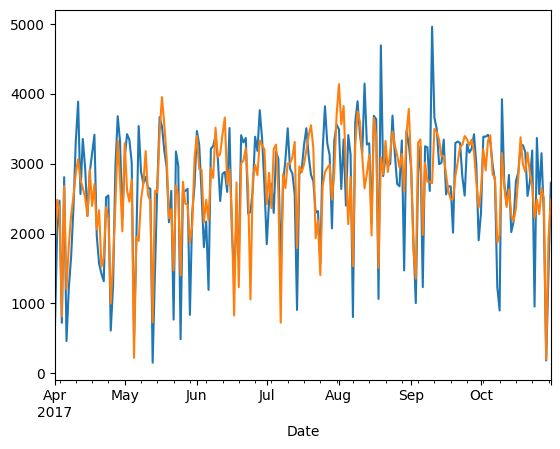

In [120]:
encoded_data['BB_COUNT'].plot()
df_forecast_poissonfunc_encoded['forecast_poissonfunc_encoded'].plot()
plt.show()

4. Оценим точность с помощью MAE

In [115]:
mean_absolute_error(y, df_forecast_mse_encoded['forecast_mse_encoded'])

407.0346754700318

In [121]:
mean_absolute_error(y, df_forecast_poissonfunc_encoded['forecast_poissonfunc_encoded'])

395.41561337972865

<div class="alert alert-info">

<h3> Задание 3</h3>
<p></p>
<ul>Преобразуйте категориальные признаки с помощью Фурье-разложения и повторите шаги 3-4 из задания 1. Какого качества моделей удалось достичь?</ul>
<p></p>
</div>